# Building a CLIP Inspired Multi-Modal Model

Submitted by: Rishabh Kaushick

# 1. Environment Setup (5%)

In [1]:
%pip install --quiet torch torchvision transformers datasets matplotlib tqdm pillow ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
%reset

## Importing Libraries

In [1]:
from datasets import load_dataset, load_from_disk

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests

from transformers import CLIPTokenizer, DistilBertTokenizer, DistilBertModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

## Setting up GPU

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.6.0
Is CUDA available: False
CUDA is not available. Running on CPU.


# 2. Dataset Selection and Exploration (10%)

For this assignment, I have decided to use the Flickr30k dataset. The reasons for this are as follows:
1.	The Flickr30k dataset contains much lesser images as compared to the COCO dataset. This will be easier to train due to the GPU limitations.
2.	The Flickr30k dataset contains high quality natural language captions. The COCO dataset has complex captions which could introduce more variability making the training process more difficult.
3.	Flickr30k dataset is suited for retrieval-based tasks.


## Save & Load Dataset

In [5]:
# Load the Flickr30k dataset from Hugging Face
dataset = load_dataset("nlphuji/flickr30k", split="test[:10000]")

# looks like the main train split is called test

I have considered the first 10k records so that it is easier to train the data with limited time and resources.

In [6]:
print(dataset)

Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 10000
})


### Save Dataset to Disk

In [7]:
# need to save the dataset in /data/flickr10k
dataset.save_to_disk("./data/flickr10k")

Saving the dataset (0/3 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

### Load Dataset from Disk

In [3]:
dataset = load_from_disk("./data/flickr10k")

In [4]:
dataset

Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 10000
})

In [5]:
dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None), 'caption': [Value(dtype='string', id=None)], 'sentids': [Value(dtype='string', id=None)], 'split': Value(dtype='string', id=None), 'img_id': Value(dtype='string', id=None), 'filename': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='flickr30k', config_name='TEST', version=1.1.0, splits={'test': SplitInfo(name='test', num_bytes=4326502343, num_examples=31014, shard_lengths=[3800, 3700, 3700, 3800, 3600, 3400, 3300, 3600, 2114], dataset_name='flickr30k')}, download_checksums={'hf://datasets/nlphuji/flickr30k@cd91f9a00273ce2e1584511cba8c10b917c488a3/TEST/test/0000.parquet': {'num_bytes': 505667437, 'checksum': None}, 'hf://datasets/nlphuji/flickr30k@cd91f9a00273ce2e1584511cba8c10b917c488a3/TEST/test/0001.parquet': {'num_bytes': 501896374, 'checksum': None}, 'hf://datasets/nlphuji/flickr30k@cd91f9a0027

In [6]:
dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'caption': [Value(dtype='string', id=None)],
 'sentids': [Value(dtype='string', id=None)],
 'split': Value(dtype='string', id=None),
 'img_id': Value(dtype='string', id=None),
 'filename': Value(dtype='string', id=None)}

In [7]:
dataset_df = dataset.to_pandas()

In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     10000 non-null  object
 1   caption   10000 non-null  object
 2   sentids   10000 non-null  object
 3   split     10000 non-null  object
 4   img_id    10000 non-null  object
 5   filename  10000 non-null  object
dtypes: object(6)
memory usage: 468.9+ KB


### Split (Train, Val, Test)

In [9]:
dataset_df['split'][0:10]

0    train
1    train
2    train
3    train
4    train
5    train
6    train
7    train
8    train
9    train
Name: split, dtype: object

Checking if we have all three in the 10k subset of the dataset.

In [10]:
split_value_counts = dataset_df['split'].value_counts()
split_value_counts

split
train    9375
test      324
val       301
Name: count, dtype: int64

Looks like we have all 3 as shown above. Now let's check how many of each set is present in the 10k records.

In [11]:
print(f"Training Set Count: {split_value_counts['train']} ({(split_value_counts['train']/10000)*100:.2f}%)")
print(f"Validation Set Count: {split_value_counts['val']} ({(split_value_counts['val']/10000)*100:.2f}%)")
print(f"Testing Set Count: {split_value_counts['test']} ({(split_value_counts['test']/10000)*100:.2f}%)")

Training Set Count: 9375 (93.75%)
Validation Set Count: 301 (3.01%)
Testing Set Count: 324 (3.24%)


We can see that the train set is more than 90%, and the test and validation sets are much smaller in comparison. 

In this project, I will use a custom train-val-test split:
- 80% training
- 10% validation 
- 10% test set

In [12]:
dataset = dataset.remove_columns('split')

In [13]:
# first creating 80% train, 20% test
train_test_data = dataset.train_test_split(test_size=0.2, seed=23)

# out of the 20% test taking half of it as train and test again for validation
val_test_data = train_test_data['test'].train_test_split(test_size=0.5, seed=23)

train_dataset = train_test_data['train']
val_dataset = val_test_data['train']
test_dataset = val_test_data['test']

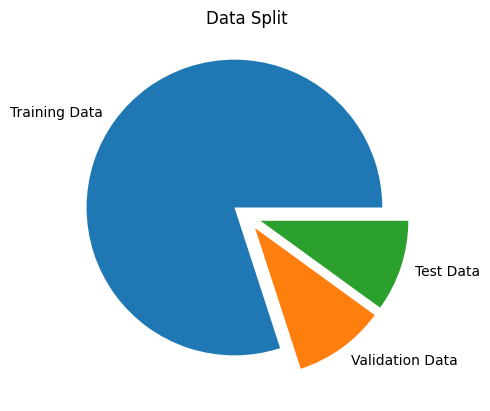

In [14]:
y = np.array([train_dataset.num_rows, val_dataset.num_rows, test_dataset.num_rows])
labels = ['Training Data', 'Validation Data', 'Test Data']
plt.pie(y, labels=labels, explode=[0.1,0.1,0.1])
plt.title("Data Split")
plt.show()

## Exploring the dataset

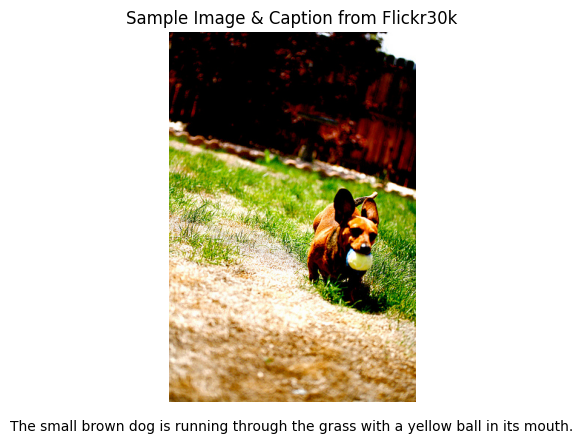

In [20]:
# Sample from the training set
sample = train_dataset[0]
image = sample["image"] 
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, caption[0], ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

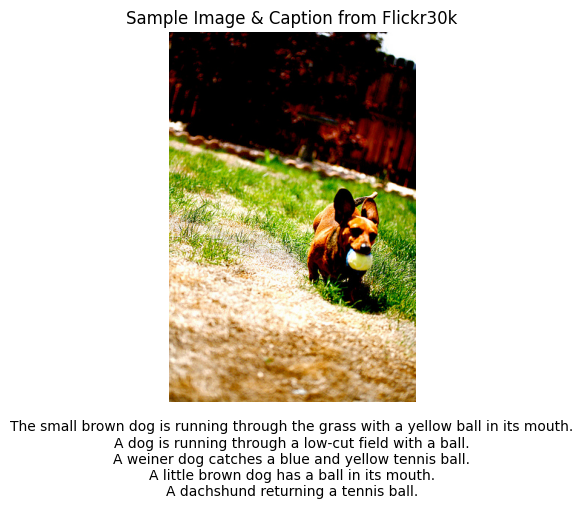

In [21]:
# Sample from the training set
sample = train_dataset[0]
image = sample["image"]
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
# Update to show all captions
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, "\n".join(caption), ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

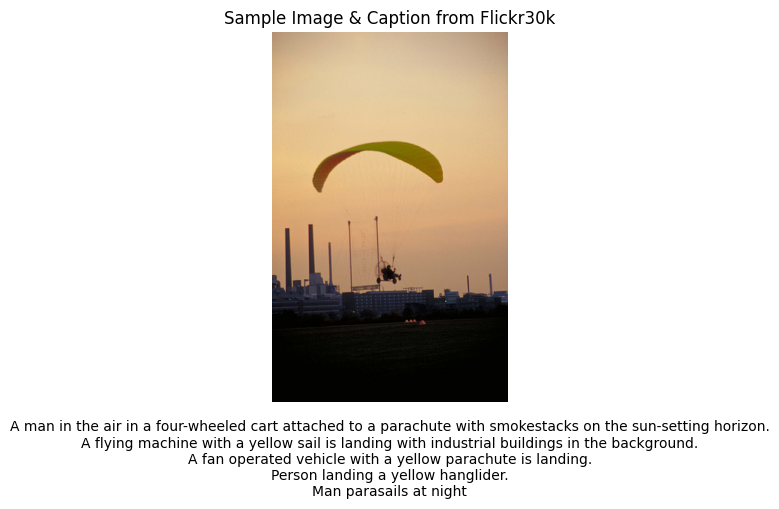

In [22]:
# Sample from the training set
sample = train_dataset[10]
image = sample["image"]
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
# Update to show all captions
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, "\n".join(caption), ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

### Dataset Characteristics

In [23]:
train_dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'caption': [Value(dtype='string', id=None)],
 'sentids': [Value(dtype='string', id=None)],
 'img_id': Value(dtype='string', id=None),
 'filename': Value(dtype='string', id=None)}

In [24]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'caption': ['The small brown dog is running through the grass with a yellow ball in its mouth.',
  'A dog is running through a low-cut field with a ball.',
  'A weiner dog catches a blue and yellow tennis ball.',
  'A little brown dog has a ball in its mouth.',
  'A dachshund returning a tennis ball.'],
 'sentids': ['42790', '42791', '42792', '42793', '42794'],
 'img_id': '8558',
 'filename': '2800934095.jpg'}

We can see from the above that for our training process, we will only require the image and the captions.

### Preprocess Images

#### Resizing Images

In [25]:
image_data = train_dataset[0]['image']
image_width, image_height = image_data.size
print(f"Width: {image_width}, Height: {image_height}")

Width: 333, Height: 500


In [26]:
image_data = train_dataset[1020]['image']
image_width, image_height = image_data.size
print(f"Width: {image_width}, Height: {image_height}")

Width: 500, Height: 443


It appears as though each image has a different width and height, which is not favorable for the model. Let's first convert them all into a standard width and height of 128 x 128. 

Image before resizing


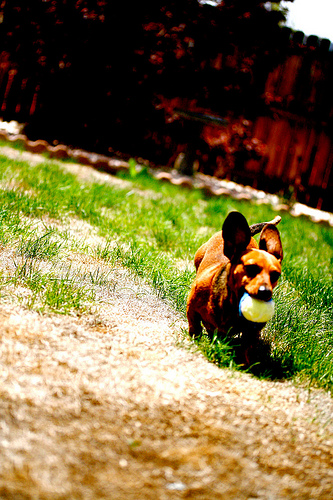

In [27]:
image_data = train_dataset[0]['image']
print("Image before resizing")
image_data


Image after resizing:


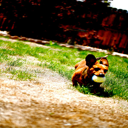

In [28]:
print("Image after resizing:")
image_data.resize((128, 128))

Now resizing all the images in the dataset:

In [29]:
def resize_image(example):
    example['resized_image'] = example['image'].resize((128, 128))
    return example

Can we use to(device) below?

In [30]:
# resizing the images in train and validation sets
resized_train_dataset = train_dataset.map(resize_image)
resized_val_dataset = val_dataset.map(resize_image)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [31]:
resized_train_dataset

Dataset({
    features: ['image', 'caption', 'sentids', 'img_id', 'filename', 'resized_image'],
    num_rows: 8000
})

In [32]:
resized_train_dataset['image'][:10]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=319x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x244>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x346>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=365x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x332>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>]

In [33]:
resized_train_dataset['resized_image'][:10]

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>]

From the above, we can see that all images have been resized.

#### Normalizing Pixel Values

Below code is inefficient, need to find better ways to find the min & max pixel values

In [34]:
min_value = np.min(resized_train_dataset['resized_image'])
max_value = np.max(resized_train_dataset['resized_image'])

In [35]:
print(f"Image pixel values range from {min_value} to {max_value}")

Image pixel values range from 0 to 255


Similarly performing normalization on all the image data.

In [36]:
def normalize_image(example):
    example['normalized_image'] = np.array(example['resized_image'])/255.0
    return example

Can we use .to(device) below?

In [37]:
preprocessed_train_dataset = resized_train_dataset.map(normalize_image)
preprocessed_val_dataset = resized_val_dataset.map(normalize_image)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [38]:
# this is taking too long to load
# resized_dataset['image'][:10]

In [39]:
preprocessed_train_dataset

Dataset({
    features: ['image', 'caption', 'sentids', 'img_id', 'filename', 'resized_image', 'normalized_image'],
    num_rows: 8000
})

In [40]:
# this is taking too long to load
# resized_dataset['image'][0]

In [41]:
subset = preprocessed_train_dataset.select(range(10))  # Access the first 10 images

In [42]:
# subset[0]['image'][0][0:10]
subset[0]['normalized_image'][0][0:10]

[[0.08627450980392157, 0.011764705882352941, 0.011764705882352941],
 [0.2823529411764706, 0.0392156862745098, 0.011764705882352941],
 [0.06666666666666667, 0.00784313725490196, 0.011764705882352941],
 [0.00784313725490196, 0.00392156862745098, 0.0],
 [0.0, 0.00392156862745098, 0.0],
 [0.0, 0.0, 0.00392156862745098],
 [0.0, 0.00392156862745098, 0.0],
 [0.0, 0.0, 0.0],
 [0.00392156862745098, 0.0, 0.0],
 [0.0, 0.0, 0.0]]

From the above, we can see that the image now has values between 0 and 1 since we normalized it.

### Tokenize Captions
I've decided to use the DistilBERT tokenizer for the captions.

In [43]:
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer = DistilBertModel.from_pretrained('distilbert-base-uncased')

Similarly creating a method to tokenize the entire captions column.

In [44]:
def tokenize_captions(example):
    example['tokenized_caption'] = tokenizer(example['caption'], max_length=77, padding="max_length", truncation=True)
    return example

In [45]:
preprocessed_train_dataset = preprocessed_train_dataset.map(tokenize_captions)
preprocessed_val_dataset = preprocessed_val_dataset.map(tokenize_captions)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [46]:
subset = preprocessed_train_dataset.select(range(0,5))

In [47]:
subset[0]['tokenized_caption'].keys()

dict_keys(['attention_mask', 'input_ids'])

In [48]:
subset[0]['tokenized_caption']['attention_mask'][0][0:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

When we tokenize the captions, the DistilBERT Tokenizer creates 'attention masks' and 'input ids' as we can see above.

# 3. Model Design (30%) 

![CLIP model design](./references/CLIP.png)

## Image Encoder

- The ResNet-18 model will be used as the backbone CNN model for feature extraction.
- The final layer of the ResNet18 will be removed
- A projection layer will be added at the end of the ResNet18 model to map data into a 512 dimension shared embedding space.

In [15]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super(ImageEncoder, self).__init__()
        # Load a pre-trained ResNet-18 model
        resnet = models.resnet18(weights=True)
        # Remove the final classification layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        # Add a projection layer to map to the joint embedding space
        self.projection = nn.Linear(512, embed_dim)
        # Normalization layer
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Extract features from the ResNet backbone
        features = self.backbone(x)
        # Flatten the features
        features = features.view(features.size(0), -1)
        # Project to embedding space
        embeddings = self.projection(features)
        # Normalize embeddings to have unit norm
        normalized_embeddings = self.norm(embeddings)
        return normalized_embeddings

## Text Encoder

- DistilBERT will be used as the backbone model for processing text.
- Most parameters except the last layer will be frozen to reduce training time. Since the DistilBERT architecture consists of 6 layers (0 to 5), we will freeze layers 0 to 4 and allow the layer 5 to updated 
during training.
- Will takes the [CLS] token embedding as the sentence representation.
- Will project this to the same 512-dimensional embedding space as the image encoder.

In [16]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super(TextEncoder, self).__init__()
        # Load pretrained DistilBERT model
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')
        # Freeze most of the transformer layers (0 to 4) to reduce training time and prevent overfitting
        for name, param in self.transformer.named_parameters():
            if 'layer.5' not in name:  # DistilBERT has 6 layers (0-5), only train the last one (layer 5)
                param.requires_grad = False
        # DistilBERT outputs 768-dimensional features- so going from 768 to 512 (same embedding size as the image):
        self.projection = nn.Linear(768, 512)
        # Normalization layer
        self.norm = nn.LayerNorm(512)
        
    def forward(self, input_ids, attention_mask):
        # Get the [CLS] token embedding from DistilBERT
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Use the [CLS] token as the sentence representation
        # For DistilBERT, this is the first token of the last hidden state
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        # Project to the joint embedding space
        embeddings = self.projection(cls_embedding)
        # Normalize embeddings to have unit norm
        normalized_embeddings = self.norm(embeddings)
        return normalized_embeddings

## CLIP Model for Shared Embedding Space

- Combines both encoders into a single model.
- Includes a method to compute contrastive loss between image and text embeddings.
- Uses temperature scaling to control the sharpness of similarity distributions.

In [17]:
class CLIPModel(nn.Module):
    def __init__(self, embed_dim=512, temperature=0.07):
        super(CLIPModel, self).__init__()
        # Create the image encoder
        self.image_encoder = ImageEncoder(embed_dim=embed_dim)
        # Create the text encoder
        self.text_encoder = TextEncoder(embed_dim=embed_dim)
        # Temperature parameter for the loss calculation
        self.temperature = temperature
        self.embed_dim = embed_dim
        
    def forward(self, images, input_ids, attention_mask):
        # Encode images and text
        image_embeddings = self.image_encoder(images)  # Shape: [batch_size, embed_dim]
        input_ids = input_ids[:, 0, :]  # Shape: [batch_size, 77]
        attention_mask = attention_mask[:, 0, :]  # Shape: [batch_size, 77]

        text_embeddings = self.text_encoder(input_ids, attention_mask)  # Shape: [batch_size, embed_dim]
        # Normalize embeddings (optional if already done in individual encoders)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
        return image_embeddings, text_embeddings
    
    def compute_contrastive_loss(self, image_embeddings, text_embeddings):
        # Compute cosine similarity matrix
        # Shape: [batch_size, batch_size]
        logits = torch.matmul(image_embeddings, text_embeddings.t()) / self.temperature
        # Create labels: diagonal elements should match (same index = positive pair)
        labels = torch.arange(logits.shape[0], device=logits.device)
        # Calculate loss for image-to-text direction
        image_loss = F.cross_entropy(logits, labels)
        # Calculate loss for text-to-image direction
        text_loss = F.cross_entropy(logits.t(), labels)
        # The total loss is the average of the two directional losses
        total_loss = (image_loss + text_loss) / 2
        return total_loss

# 4. Training Process (30%)

## Setting up the hyper-parameters

In [18]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# initialize hyper parameters
embed_dim = 512
batch_size = 64
num_epochs = 10
learning_rate = 1e-4

# tokenizer
# tokenizer = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Using device: cpu


## Creating Dataset 

While creating the dataset, we need to create a transforms pipeline to preprocess the data the same way we processed it above.

In [19]:
transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # normalizing vales are based on the standard normalization parameters from the original ResNet-18 documentation
    ])

### ImageTextDataset
This will be a custom Dataset that contains the images and the corresponding captions. 

In [20]:
class ImageTextDataset(Dataset):
    def __init__(self, images, captions, tokenizer, transform=None, max_length=77):
        self.images = images
        self.captions = captions
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load and transform image
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
            
        # Tokenize text
        caption = self.captions[idx]
        encoding = self.tokenizer(
            caption,
            return_tensors='pt',
            max_length=77, # the original CLIP paper uses max_length as 77
            # 77 tokens provides enough context to capture meaningful text descriptions while remaining computationally efficient
            padding='max_length',
            truncation=True
        )
        
        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'caption': caption  # Keep original caption for reference
        }


The below code does all the preprocessing in one step and creates it as a ImageTextDataset:

In [21]:
# when I was taking the data without preprocessing it first

train_dataset = ImageTextDataset(
    train_dataset['image'], 
    train_dataset['caption'], 
    tokenizer, 
    transform=transform
)

val_dataset = ImageTextDataset(
    val_dataset['image'], 
    val_dataset['caption'], 
    tokenizer, 
    transform=transform
)

Now the train_dataset & val_dataset have been processed and are objects of type 'ImageTextDataset'

In [22]:
type(train_dataset)

__main__.ImageTextDataset

## Creating DataLoaders

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
    
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## Training Loop

In [25]:
def train_clip_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device='cuda'):
    # Move model to device
    model = model.to(device)
    
    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Learning rate scheduler (optional)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training and validation metrics
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in pbar:
            # Move data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Zero gradients
            optimizer.zero_grad()

            # input_ids = input_ids[:, 0, :]  # Shape: [64, 77]
            # attention_mask = attention_mask[:, 0, :]  # Shape: [64, 77]

            # print("Input IDs shape:", input_ids.shape) # Input IDs shape: torch.Size([64, 77])
            # print("Attention mask shape:", attention_mask.shape) # Attention mask shape: torch.Size([64, 77])
            
            # Forward pass
            image_embeddings, text_embeddings = model(images, input_ids, attention_mask)
            
            # Compute loss
            loss = model.compute_contrastive_loss(image_embeddings, text_embeddings)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix({'loss': loss.item()})
        
        # Update learning rate
        scheduler.step()
        
        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch in pbar:
                # Move data to device
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                # input_ids = input_ids[:, 0, :]  # Shape: [64, 77]
                # attention_mask = attention_mask[:, 0, :]  # Shape: [64, 77]

                
                # Forward pass
                image_embeddings, text_embeddings = model(images, input_ids, attention_mask)
                
                # Compute loss
                loss = model.compute_contrastive_loss(image_embeddings, text_embeddings)
                
                # Update metrics
                val_loss += loss.item()
                val_batches += 1
                pbar.set_postfix({'loss': loss.item()})
        
        # Calculate average validation loss for this epoch
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save checkpoint (optional)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, f'./results/clip_checkpoint_epoch_{epoch+1}.pt')
    
    # Return training history
    return train_losses, val_losses

## Start Training

In [25]:
# Initialize model
model = CLIPModel(embed_dim=embed_dim)

# Train model
train_losses, val_losses = train_clip_model(
    model,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    lr=learning_rate,
    device=device
)

/opt/homebrew/anaconda3/envs/csye7230/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Val]: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it, loss=2.07]


Epoch 1/10 - Train Loss: 2.9882, Val Loss: 2.3605


Epoch 2/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it, loss=2]   


Epoch 2/10 - Train Loss: 1.5586, Val Loss: 2.1600


Epoch 3/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it, loss=1.82]


Epoch 3/10 - Train Loss: 0.7418, Val Loss: 2.1818


Epoch 4/10 [Val]: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it, loss=2.01]


Epoch 4/10 - Train Loss: 0.3890, Val Loss: 2.2110


Epoch 5/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it, loss=1.89]


Epoch 5/10 - Train Loss: 0.2519, Val Loss: 2.2644


Epoch 6/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.27s/it, loss=1.98]


Epoch 6/10 - Train Loss: 0.1882, Val Loss: 2.2816


Epoch 7/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it, loss=1.98]


Epoch 7/10 - Train Loss: 0.1500, Val Loss: 2.3036


Epoch 8/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it, loss=1.95]


Epoch 8/10 - Train Loss: 0.1329, Val Loss: 2.3146


Epoch 9/10 [Val]: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it, loss=1.96]


Epoch 9/10 - Train Loss: 0.1250, Val Loss: 2.3270


Epoch 10/10 [Val]: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it, loss=1.96]


Epoch 10/10 - Train Loss: 0.1168, Val Loss: 2.3233


## Save Best Model

In [26]:
# After training your model
torch.save(model.state_dict(), './results/best_model.pth')

## Load Saved Model

In [26]:
# Initialize model (if not already done)
model = CLIPModel(embed_dim=embed_dim)

model.load_state_dict(torch.load('./results/best_model.pth'))
model.eval()  # Set the model to evaluation mode

/opt/homebrew/anaconda3/envs/csye7230/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CLIPModel(
  (image_encoder): ImageEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

# 5. Evaluation and Results (20%)

## Training & Validation Loss Curve

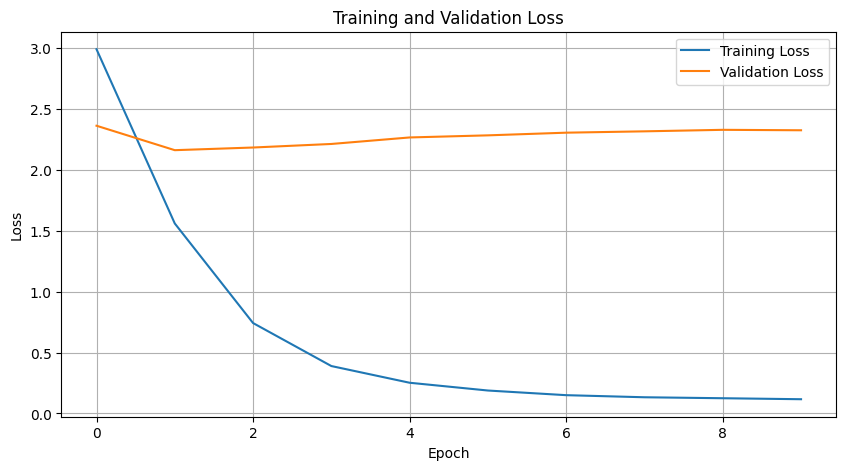

In [28]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(train_losses, val_losses)

## Evaluation Metrics

In [78]:
def evaluate_retrieval(model, data_loader, device='cuda'):
    
    model.eval()
    
    # Lists to store all embeddings, captions, and images
    all_image_embeddings = []
    all_text_embeddings = []
    all_captions = []
    all_images = []
    
    # Extract embeddings for all examples
    print("Extracting embeddings...")
    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Move batch data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Get embeddings
            image_embeddings, text_embeddings = model(images, input_ids, attention_mask)
            
            # Store embeddings and metadata
            all_image_embeddings.append(image_embeddings.cpu())
            all_text_embeddings.append(text_embeddings.cpu())
            all_captions.extend(batch['caption'])
            all_images.append(images.cpu())
    
    # Concatenate all embeddings
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0)
    all_images = torch.cat(all_images, dim=0)
    
    # Normalize embeddings for cosine similarity
    all_image_embeddings = all_image_embeddings / all_image_embeddings.norm(dim=1, keepdim=True)
    all_text_embeddings = all_text_embeddings / all_text_embeddings.norm(dim=1, keepdim=True)
    
    # Calculate similarity matrices
    # text-to-image: each row represents text, each column represents image
    text_to_image_sim = torch.matmul(all_text_embeddings, all_image_embeddings.t())
    
    # image-to-text: each row represents image, each column represents text
    image_to_text_sim = text_to_image_sim.t()
    
    # Calculate retrieval metrics
    print("Calculating retrieval metrics...")
    
    # For each text, get the rank of the matching image
    text_to_image_ranks = []
    for i in range(len(all_captions)):
        # Get similarities for this text
        similarities = text_to_image_sim[i]
        
        # Get the rank of the matching image (should be index i)
        # We want the matching image to have highest similarity, so its rank should be 0
        # -similarities: to sort in descending order
        # We add 1 to go from 0-indexed to 1-indexed rank
        rank = ((-similarities).argsort() == i).nonzero().item() + 1
        text_to_image_ranks.append(rank)
    
    # For each image, get the rank of the matching text
    image_to_text_ranks = []
    for i in range(len(all_captions)):
        # Get similarities for this image
        similarities = image_to_text_sim[i]
        
        # Get the rank of the matching text
        rank = ((-similarities).argsort() == i).nonzero().item() + 1
        image_to_text_ranks.append(rank)
    
    # Calculate metrics
    metrics = {
        # Recall@K measures the percentage of queries where the correct item is in the top K results
        'text_to_image_recall@1': np.mean([1 if r <= 1 else 0 for r in text_to_image_ranks]),
        'text_to_image_recall@5': np.mean([1 if r <= 5 else 0 for r in text_to_image_ranks]),
        'text_to_image_recall@10': np.mean([1 if r <= 10 else 0 for r in text_to_image_ranks]),
        
        'image_to_text_recall@1': np.mean([1 if r <= 1 else 0 for r in image_to_text_ranks]),
        'image_to_text_recall@5': np.mean([1 if r <= 5 else 0 for r in image_to_text_ranks]),
        'image_to_text_recall@10': np.mean([1 if r <= 10 else 0 for r in image_to_text_ranks]),
        
        # Mean Rank
        'text_to_image_mean_rank': np.mean(text_to_image_ranks),
        'image_to_text_mean_rank': np.mean(image_to_text_ranks),
        
        # Mean Reciprocal Rank (MRR)
        'text_to_image_mrr': np.mean([1/r for r in text_to_image_ranks]),
        'image_to_text_mrr': np.mean([1/r for r in image_to_text_ranks]),
    }
    

    
    # Generate some example retrievals for visualization
    # print("\nGenerating example retrievals...")
    
    # Select a few random examples
    num_examples = min(5, len(all_captions))
    example_indices = np.random.choice(range(len(all_captions)), num_examples, replace=False)
    
    examples = []
    for idx in example_indices:
        # Text-to-image retrieval
        text_query = all_captions[idx]
        text_embedding = all_text_embeddings[idx].unsqueeze(0)
        image_similarities = torch.matmul(text_embedding, all_image_embeddings.t()).squeeze(0)
        
        # Get top 5 most similar images
        top_image_indices = torch.argsort(image_similarities, descending=True)[:5]
        
        t2i_example = {
            'query': text_query,
            'top_images': all_images[top_image_indices],
            'ground_truth_rank': (top_image_indices == idx).nonzero().item() + 1 if idx in top_image_indices else ">5"
        }
        
        # Image-to-text retrieval
        image_query = all_images[idx]
        image_embedding = all_image_embeddings[idx].unsqueeze(0)
        text_similarities = torch.matmul(image_embedding, all_text_embeddings.t()).squeeze(0)
        
        # Get top 5 most similar texts
        top_text_indices = torch.argsort(text_similarities, descending=True)[:5]
        # print("Length of all captions: ", len(all_captions))
        # print(len(top_text_indices))
        top_captions = [all_captions[i] for i in top_text_indices if i < len(all_captions)]
        # top_captions = [all_captions[i] for i in top_text_indices]
        
        i2t_example = {
            'query_image': image_query,
            'top_captions': top_captions,
            'ground_truth_rank': (top_text_indices == idx).nonzero().item() + 1 if idx in top_text_indices else ">5"
        }
        
        examples.append({
            'text_to_image': t2i_example,
            'image_to_text': i2t_example
        })
    
    # Return metrics and examples
    return {
        'metrics': metrics,
        'examples': examples
    }

In [79]:
# Display the image

def show_tensor_image(tensor_image, title=None):
    # Convert tensor to numpy and transpose from [C, H, W] to [H, W, C]
    image = tensor_image.permute(1, 2, 0).numpy()
    
    # Denormalize the image (if it was normalized during preprocessing)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip values to be between 0 and 1
    image = np.clip(image, 0, 1)
    
    # Create figure and display image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [80]:
# Visualize successful matches at Recall@k
def visualize_successful_matches(metrics_result, k=1, mode='text_to_image'):
    examples = metrics_result['examples']
    
    for idx, example in enumerate(examples):
        result = example[mode]
        
        # Check if this is a successful match (rank <= k)
        if result['ground_truth_rank'] <= k:
            print(f"\nSuccessful {mode} match (Rank {result['ground_truth_rank']}):")
            
            if mode == 'text_to_image':
                # Show query text
                print(f"Query text: {result['query']}")
                
                # Show top matched image
                show_tensor_image(result['top_images'][0], 
                                title=f"Top matched image (Rank {result['ground_truth_rank']})")
            
            else:  # image_to_text
                # Show query image
                print("Query image:")
                show_tensor_image(result['query_image'])
                
                # Show top matched caption
                print(f"Top matched caption: {result['top_captions'][0]}")

In [87]:
def print_detailed_metrics(metrics_result):
    metrics = metrics_result['metrics']
    
    print("\nRetrieval Results:")
    print("Text-to-Image Retrieval:")
    print(f"  Recall@1: {metrics['text_to_image_recall@1']:.4f}")
    print(f"  Recall@5: {metrics['text_to_image_recall@5']:.4f}")
    print(f"  Recall@10: {metrics['text_to_image_recall@10']:.4f}")
    print(f"  Mean Rank: {metrics['text_to_image_mean_rank']:.2f}")
    print(f"  MRR: {metrics['text_to_image_mrr']:.4f}")
    
    print("\nImage-to-Text Retrieval:")
    print(f"  Recall@1: {metrics['image_to_text_recall@1']:.4f}")
    print(f"  Recall@5: {metrics['image_to_text_recall@5']:.4f}")
    print(f"  Recall@10: {metrics['image_to_text_recall@10']:.4f}")
    print(f"  Mean Rank: {metrics['image_to_text_mean_rank']:.2f}")
    print(f"  MRR: {metrics['image_to_text_mrr']:.4f}")

In [55]:
train_metrics = evaluate_retrieval(model, train_loader, device)

Extracting embeddings...


100%|██████████| 125/125 [03:09<00:00,  1.51s/it]


Calculating retrieval metrics...

Retrieval Results:
Text-to-Image Retrieval:
  Recall@1: 0.8720
  Recall@5: 0.9936
  Recall@10: 1.0000
  Mean Rank: 1.23
  MRR: 0.9251

Image-to-Text Retrieval:
  Recall@1: 0.9136
  Recall@5: 0.9888
  Recall@10: 0.9968
  Mean Rank: 1.22
  MRR: 0.9500

Generating example retrievals...


Successful Text-to-Image Matches:

Successful text_to_image match (Rank 1):
Query text: ('A young boy in a blue golf shirt and khaki shorts is practicing his gold swing.', 'A young black man shouts into a microphone while a young white man shouts back.', 'Two boy put their hands together while another boy goes under their hands.', 'A white-haired woman wearing a blue shirt is squatting with three cats near her.', 'A woman in a headscarf stands by a garden of white flowers.', 'An elderly man and child in front of a fire', 'A young boy holding a newspaper that shows a murder of a man on the cover.', 'Older women and younger girl are opening presents up.', 'Two elaborately costumed people applying face paint.', 'The young asian boy looks at his reflection in the park.', 'A band performs at on an outdoor stage.', 'A land rover is being driven across a river.', 'A motocross bike is being ridden over rocks.', 'Three older Asian women are sitting on the ground.', 'An asian male walking toward

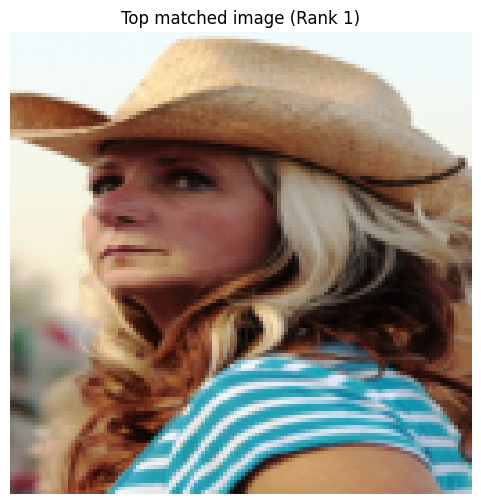


Successful text_to_image match (Rank 1):
Query text: ('A black and white dog running down a blue ramp with his mouth open.', 'A little girl walking on a variation of a hopscotch board on a concrete surface.', 'A young man, who appears to be from a Central American nation, stirs a large cauldron of some sort of semi-liquid food in the shade at an outdoor kitchen, while a little girl in the background speaks to someone on a bicycle.', 'A man wearing a gray and black shirt and blue jeans sells inflatable brightly colored toys.', 'A dog walking along a cracked and ashen surface.', 'A man in jeans and a white t-shirt chops up vegetables in a kitchen.', 'Some Black children are standing and looking at a device.', 'A woman is clapping her hands while running in front of a running brown dog.', 'Woman wearing a dark blue hat in the middle of a bunch of vegetables.', 'A woman in a plaid shirt and green apron is working in a red tub', 'A young child and an older man are both petting a goat.', 'T

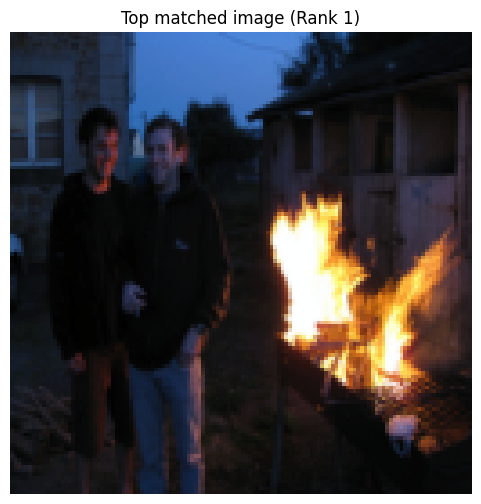


Successful text_to_image match (Rank 1):
Query text: ('A uniformed woman holding a camera standing in front of a crowd of spectators.', 'Two dogs run across dry ground.', 'A girl, in a green field, plays soccer.', 'A five member band is playing in a dimly lit studio.', 'A man on a roller scooter holding on to rope', 'A man in an apron smokes behind his market booth.', 'Two young fishermen reaping the fruits of their labor.', 'A woman sitting down to have a meal is being pointed at.', 'The football player runs with the ball across the field.', 'An elderly man with a red shirt and glasses sits under an umbrella.', 'Man helps another person reach the top of a rock they are climbing.', 'View of busy pedestrians along a road in Asia.', 'A man is rowing a canoe in a body of water.', 'A man in a blue jacket standing at a table with his back to the camera.', 'Small dog being dried by a handheld hair blower.', 'Cheerleaders in blue waiting in the stands.', 'People conversing at a party outside

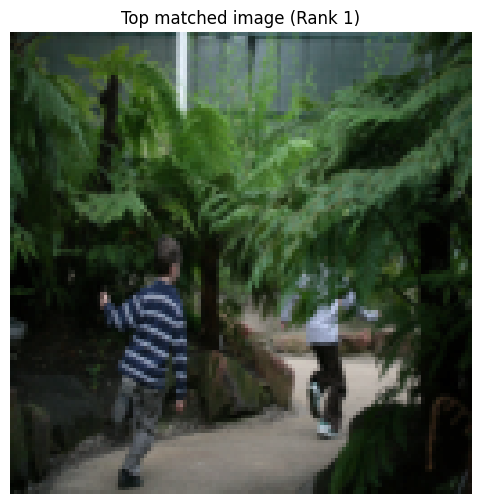


Successful text_to_image match (Rank 1):
Query text: ('A man wearing a green headband is working on a construction project.', 'A white dog jumps to catch a blue ball in a living room.', 'A bellhop is pushing luggage around inside a hotel.', 'A man in a cap and blue shirt pretends to choke a girl.', 'A young lady wearing yellow is feeding a small child at the table.', 'A young girl in a red dress walking down a forest path with a deer trailing behind her.', 'A black man in a white shirt looks tired while a black women stirs a pot.', 'A white and black dog leaps into water.', 'Girl is wading through the gray ocean.', 'A tennis player dressed in white is hitting a tennis ball.', 'A man cleaning windows on the 3rd story of a mansion', 'A girl in a white outfit with a yellow belt is holding a trophy.', 'The man in the straw hat is smoking a cigarette.', 'One woman is being carried behind three people who are walking on path.', 'People lay out vegetables on blankets at a street market.', 'A

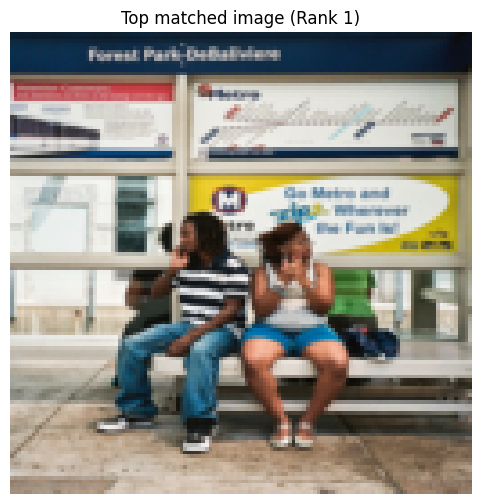


Successful text_to_image match (Rank 1):
Query text: ('Shirtless construction worker builds interior of home.', 'A lady and a kid in a strawberry ride', 'A woman carrying a bag is smoking.', 'A woman cooking food on hot stove.', 'A girl reaches up to look into a pool.', 'An old woman brings a cake to a group of children.', 'A man on a bicycle rides past a bright blue door.', 'Making something tasty hope you like lemons!', 'Emergency workers clearing the path.', 'Two young siblings walk while holding hands.', 'Two men are playing guitar in the hallway.', 'A group of people waving a flag on stage', 'A dog sled team seen from behind.', 'Two people sleep on a couch.', 'A boy with a winged bug perched on his nose.', 'A bicycle rider is crossing a street.', 'A man steps out of a blue porta potty.', 'A brown dog is carrying a ball up the road.', 'Six people jump for ball.', 'A young boy waving a streaming kite', 'A boy swings in the air.', 'A man kayaks in rough water.', 'A man on stage as p

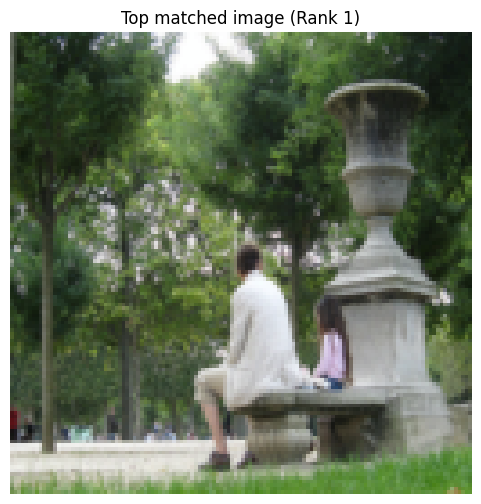

In [82]:
# Visualize successful text-to-image matches at Recall@1
print("Successful Text-to-Image Matches:")
visualize_successful_matches(train_metrics, k=1, mode='text_to_image')


Successful Image-to-Text Matches:

Successful image_to_text match (Rank 1):
Query image:


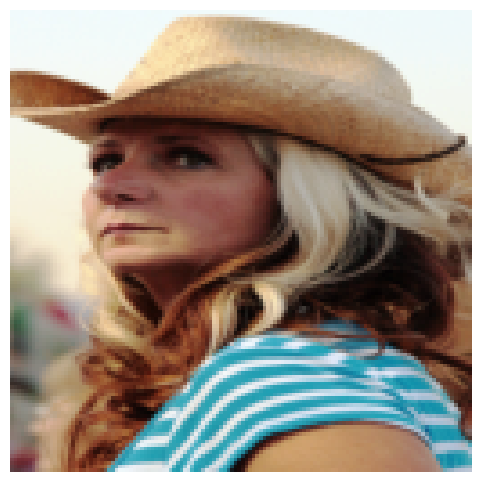

Top matched caption: ('A young boy in a blue golf shirt and khaki shorts is practicing his gold swing.', 'A young black man shouts into a microphone while a young white man shouts back.', 'Two boy put their hands together while another boy goes under their hands.', 'A white-haired woman wearing a blue shirt is squatting with three cats near her.', 'A woman in a headscarf stands by a garden of white flowers.', 'An elderly man and child in front of a fire', 'A young boy holding a newspaper that shows a murder of a man on the cover.', 'Older women and younger girl are opening presents up.', 'Two elaborately costumed people applying face paint.', 'The young asian boy looks at his reflection in the park.', 'A band performs at on an outdoor stage.', 'A land rover is being driven across a river.', 'A motocross bike is being ridden over rocks.', 'Three older Asian women are sitting on the ground.', 'An asian male walking towards a group of people that are walking towards him.', 'A singing grou

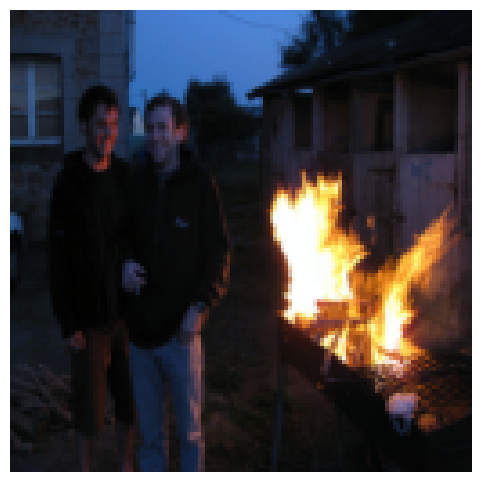

Top matched caption: ('A black and white dog running down a blue ramp with his mouth open.', 'A little girl walking on a variation of a hopscotch board on a concrete surface.', 'A young man, who appears to be from a Central American nation, stirs a large cauldron of some sort of semi-liquid food in the shade at an outdoor kitchen, while a little girl in the background speaks to someone on a bicycle.', 'A man wearing a gray and black shirt and blue jeans sells inflatable brightly colored toys.', 'A dog walking along a cracked and ashen surface.', 'A man in jeans and a white t-shirt chops up vegetables in a kitchen.', 'Some Black children are standing and looking at a device.', 'A woman is clapping her hands while running in front of a running brown dog.', 'Woman wearing a dark blue hat in the middle of a bunch of vegetables.', 'A woman in a plaid shirt and green apron is working in a red tub', 'A young child and an older man are both petting a goat.', 'Two men who look very similar with

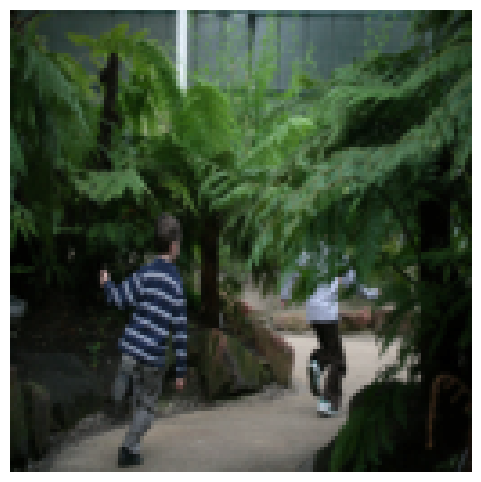

Top matched caption: ('A uniformed woman holding a camera standing in front of a crowd of spectators.', 'Two dogs run across dry ground.', 'A girl, in a green field, plays soccer.', 'A five member band is playing in a dimly lit studio.', 'A man on a roller scooter holding on to rope', 'A man in an apron smokes behind his market booth.', 'Two young fishermen reaping the fruits of their labor.', 'A woman sitting down to have a meal is being pointed at.', 'The football player runs with the ball across the field.', 'An elderly man with a red shirt and glasses sits under an umbrella.', 'Man helps another person reach the top of a rock they are climbing.', 'View of busy pedestrians along a road in Asia.', 'A man is rowing a canoe in a body of water.', 'A man in a blue jacket standing at a table with his back to the camera.', 'Small dog being dried by a handheld hair blower.', 'Cheerleaders in blue waiting in the stands.', 'People conversing at a party outside.', 'A girl runs through the wate

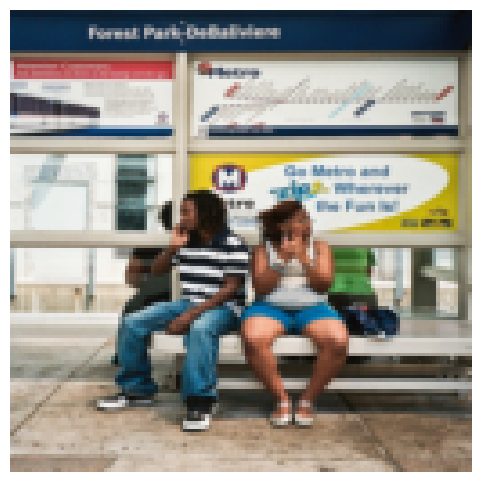

Top matched caption: ('A man wearing a green headband is working on a construction project.', 'A white dog jumps to catch a blue ball in a living room.', 'A bellhop is pushing luggage around inside a hotel.', 'A man in a cap and blue shirt pretends to choke a girl.', 'A young lady wearing yellow is feeding a small child at the table.', 'A young girl in a red dress walking down a forest path with a deer trailing behind her.', 'A black man in a white shirt looks tired while a black women stirs a pot.', 'A white and black dog leaps into water.', 'Girl is wading through the gray ocean.', 'A tennis player dressed in white is hitting a tennis ball.', 'A man cleaning windows on the 3rd story of a mansion', 'A girl in a white outfit with a yellow belt is holding a trophy.', 'The man in the straw hat is smoking a cigarette.', 'One woman is being carried behind three people who are walking on path.', 'People lay out vegetables on blankets at a street market.', 'A little girl wearing blue shorts 

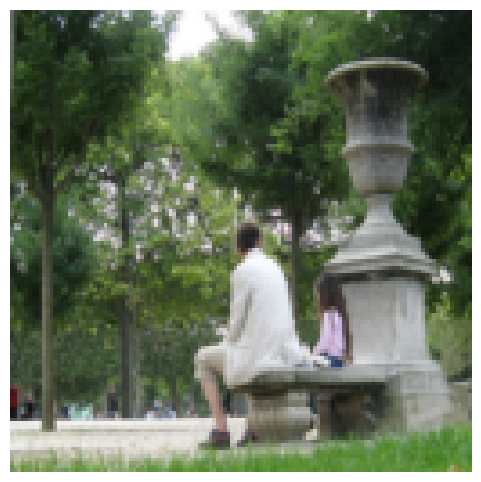

Top matched caption: ('Shirtless construction worker builds interior of home.', 'A lady and a kid in a strawberry ride', 'A woman carrying a bag is smoking.', 'A woman cooking food on hot stove.', 'A girl reaches up to look into a pool.', 'An old woman brings a cake to a group of children.', 'A man on a bicycle rides past a bright blue door.', 'Making something tasty hope you like lemons!', 'Emergency workers clearing the path.', 'Two young siblings walk while holding hands.', 'Two men are playing guitar in the hallway.', 'A group of people waving a flag on stage', 'A dog sled team seen from behind.', 'Two people sleep on a couch.', 'A boy with a winged bug perched on his nose.', 'A bicycle rider is crossing a street.', 'A man steps out of a blue porta potty.', 'A brown dog is carrying a ball up the road.', 'Six people jump for ball.', 'A young boy waving a streaming kite', 'A boy swings in the air.', 'A man kayaks in rough water.', 'A man on stage as people watch him and wave arms.', 

In [83]:
# Visualize successful image-to-text matches at Recall@1
print("\nSuccessful Image-to-Text Matches:")
visualize_successful_matches(train_metrics, k=1, mode='image_to_text')

In [91]:
print_detailed_metrics(train_metrics)


Retrieval Results:
Text-to-Image Retrieval:
  Recall@1: 0.8720
  Recall@5: 0.9936
  Recall@10: 1.0000
  Mean Rank: 1.23
  MRR: 0.9251

Image-to-Text Retrieval:
  Recall@1: 0.9136
  Recall@5: 0.9888
  Recall@10: 0.9968
  Mean Rank: 1.22
  MRR: 0.9500


In [84]:
val_metrics = evaluate_retrieval(model, val_loader, device)

Extracting embeddings...


100%|██████████| 16/16 [00:22<00:00,  1.38s/it]

Calculating retrieval metrics...


In [89]:
print_detailed_metrics(val_metrics)


Retrieval Results:
Text-to-Image Retrieval:
  Recall@1: 0.0875
  Recall@5: 0.2500
  Recall@10: 0.3750
  Mean Rank: 84.79
  MRR: 0.1713

Image-to-Text Retrieval:
  Recall@1: 0.0875
  Recall@5: 0.2750
  Recall@10: 0.3875
  Mean Rank: 83.31
  MRR: 0.1781


# 6. Challenges and Insights (10%)

## Challenges

From the evaluation above, we can see that the training retrieval metrics are very high, however the evaluation retrieval metrics are very low. This is also visible from the training and evaluation loss graph:

![Train Validation Loss Graph](./results/train_val_loss_graph.png)

This graph shows that only the training loss keeps reducing. We can see that the validation loss starts initially reducing but later gets worse.

Furthermore when we visualize the text and image pairs together, we see that they do not make semantic sense as shown below:

![](./results/visualization_results.png)

## Future Improvement Areas

Based on the above information, it is clear to say that this CLIP model has overfit the training data. The model seems to be memorizing the image and text pairs but when looking at new data in the validation set, it is struggling to make sense of it.

The possible Causes of over-fitting are:
1. The training set is too small. In this project, only 10k subset of data has been used, but in the future we can try this with the entire 30k dataset along with other datasets.
2. Currently the model may be too powerful relative to the data.
3. The training setup is not focusing on generalization. We can add more regularization and train on lesser epochs to avoid this.

# 7. Conclusion

In this project, I built a multi-modal retrieval model inspired by CLIP, aiming to represent image and text representations in a shared embedding space. The model achieved high performance on the training set, with Recall@1 exceeding 87% for text-to-image retrieval and 91% for image-to-text retrieval. These strong training metrics indicate that the model successfully learned to associate image-text pairs within the training distribution.

However, evaluation on the validation set revealed a significant drop in performance, with Recall@1 around 8.75% for both retrieval tasks and a substantially higher mean rank. Furthermore, qualitative analysis showed that retrieved image-text pairs often lacked semantic similarity. These observations suggest that while the model memorized the training set effectively, it struggled to generalize to unseen examples — indicating  overfitting.

Future work will focus on improving generalization through techniques such as better regularization, data augmentation, and more robust evaluation strategies.
